In [1]:
# ref: http://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
import numpy as np
import re
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

In [2]:
# utility
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

def word_tokenize(sent):
    return [x.strip() for x in re.split('(\W+)?', sent) if x.strip()]

In [3]:
n_samples = 10000
data_path = 'fra-eng/fra.txt' # you have to download dataset from http://www.manythings.org/anki/
max_sentence_len = 6
UNK = '<UNK>'
SOS = '<SOS>'
EOS = '<EOS>'
input_texts, target_texts = [], []
input_vocab, target_vocab = set(), set()
lines = open(data_path).read().split('\n')
for line in lines[:min(n_samples, len(lines) -1)]:
    in_txt, tg_txt = line.split('\t', 1)
    in_txt = word_tokenize(in_txt) + [EOS]
    tg_txt = word_tokenize(tg_txt) + [EOS]
    if len(in_txt) > max_sentence_len or len(tg_txt) > max_sentence_len: continue # skip difficult sentence
    input_texts.append(in_txt)
    target_texts.append(tg_txt)
    for w in in_txt:
        if w not in input_vocab:
            input_vocab.add(w)
    for w in tg_txt:
        if w not in target_vocab:
            target_vocab.add(w)

input_vocab = [UNK, SOS, EOS] + sorted(list(input_vocab))
target_vocab = [UNK, SOS, EOS] + sorted(list(target_vocab)) 
n_input_vocab = len(input_vocab)
n_target_vocab = len(target_vocab)
max_encoder_seq_len = max([len(txt) for txt in input_texts])
max_decoder_seq_len = max([len(txt) for txt in target_texts])
print('N', len(input_texts), '==', len(target_texts))
print('n_input_vocab', n_input_vocab)
print('n_target_vocab', n_target_vocab)
print('max enc len', max_encoder_seq_len)
print('max dec len', max_decoder_seq_len)

N 5424 == 5424
n_input_vocab 1730
n_target_vocab 3040
max enc len 6
max dec len 6


/home/jonki/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [4]:
input_w2i = {w:i for i,w in enumerate(input_vocab)}
input_i2w = {i:w for i,w in enumerate(input_vocab)}
target_w2i = {w:i for i,w in enumerate(target_vocab)}
target_i2w = {i:w for i,w in enumerate(target_vocab)}
print('input:', input_texts[0])
print('target:', target_texts[0])

input: ['Go', '.', '<EOS>']
target: ['Va', '!', '<EOS>']


In [5]:
class EncodeRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncodeRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
    
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1) # torch.Size([1, 1, 100])
        
        output = embedded
        for _ in range(self.n_layers):
            output, hidden = self.gru(output, hidden)
        return output, hidden
    
    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [7]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1):
        super(DecoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden, dummy1, dummy2):
        output = self.embedding(input).view(1, 1, -1)
        for _ in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.out(output[0]))
        return output, hidden, None # last one is dummy atten_weights
    
    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda: return result.cuda()
        else: return result

In [8]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1, max_length=10):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size*2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size*2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input, hidden, encoder_ouput, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)))
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0)) # Performs a batch matrix-matrix product of matrices stored in batch1 and batch2.
        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        
        for _ in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)
            
        output = F.log_softmax(self.out(output[0]))
        return output, hidden, attn_weights
    
    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda: return result.cuda()
        else: return result

In [9]:
def train(input_var, target_var, encoder, decoder, enc_optim, dec_optim, criterion, max_length):
    enc_optim.zero_grad()
    dec_optim.zero_grad()
    
    input_length = input_var.size()[0]
    target_length = target_var.size()[0]
    
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    if use_cuda: encoder_outputs = encoder_outputs.cuda()
    
    loss = 0
    encoder_hiden = encoder.initHidden()
    for ei in range(input_length):
        encoder_output, encoder_hiden = encoder(input_var[ei], encoder_hiden)
        encoder_outputs[ei] = encoder_output[0][0]
        
    decoder_input = Variable(torch.LongTensor([[target_w2i[SOS]]]))
    if use_cuda: decoder_input = decoder_input.cuda()

    decoder_hidden = encoder_hiden
    use_teacher_forcing = True if random.random() < 0.5 else False
    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_output, encoder_outputs
        )
        if use_teacher_forcing:
            loss += criterion(decoder_output, target_var[di])
            decoder_input = target_var[di] # teacher_forcing
        else:
            top_val, top_ind = decoder_output.data.topk(1)
            ni = top_ind[0][0]

            decoder_input = Variable(torch.LongTensor([[ni]]))
            if use_cuda: decoder_input = decoder_input.cuda()

            loss += criterion(decoder_output, target_var[di])
            if ni == target_w2i[EOS]:
                break

    loss.backward()
    enc_optim.step()
    dec_optim.step()
    
    return loss.data[0] / target_length

In [13]:
def variableFromSentence(sentence, w2i):
    index_vector = [w2i[w] for w in sentence]
    index_vector += [w2i[EOS]]
    result = Variable(torch.LongTensor(index_vector).view(-1, 1))
    if use_cuda: result = result.cuda()
    return result

def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    input_variables = [variableFromSentence(random.choice(input_texts), input_w2i) for i in range(n_iters)]
    target_variables = [variableFromSentence(random.choice(target_texts), target_w2i) for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        input_variable = input_variables[iter - 1]
        target_variable = target_variables[iter - 1]

        loss = train(input_variable, target_variable, encoder, decoder, 
                     encoder_optimizer, decoder_optimizer, criterion, 10)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('iter_count={:d} ({:.1f}%), loss={:.4f}'.format(iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)
    
hidden_size = 100
def run(encoder, decoder):
    if use_cuda:
        encoder = encoder.cuda()
        decoder = decoder.cuda()
    trainIters(encoder, decoder, 5000)

Simple Sequence to Sequence
iter_count=1000 (20.0%), loss=3.6935
iter_count=2000 (40.0%), loss=3.4521
iter_count=3000 (60.0%), loss=3.3131
iter_count=4000 (80.0%), loss=3.2534
iter_count=5000 (100.0%), loss=3.1807


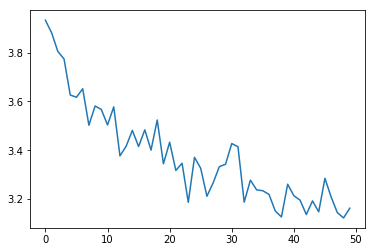

In [14]:
print('Simple Sequence to Sequence')
run(EncodeRNN(n_input_vocab, hidden_size), DecoderRNN(hidden_size, n_target_vocab))

Attentive Sequence to Sequence
iter_count=1000 (20.0%), loss=3.7617
iter_count=2000 (40.0%), loss=3.4039
iter_count=3000 (60.0%), loss=3.2607
iter_count=4000 (80.0%), loss=3.2405
iter_count=5000 (100.0%), loss=3.2006


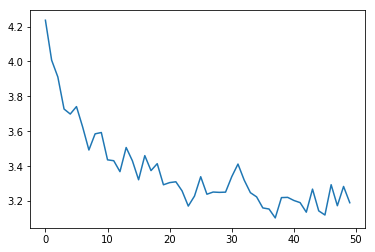

In [15]:
print('Attentive Sequence to Sequence')
run(EncodeRNN(n_input_vocab, hidden_size), AttnDecoderRNN(hidden_size, n_target_vocab))